# 1.Installing libraries

In [1]:
!pip install gdown

In [2]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 50.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 89.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 6.6 MB/s eta 0:00:00


In [3]:
import requests
import zipfile
import gdown

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, RandomRotation, RandomResizedCrop
import torchvision.transforms as transforms

import streamlit as st
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
import numpy as np
import cv2
import os

# 2.1.installing data from drive

In [4]:
url = 'https://drive.google.com/file/d/1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY/view?usp=drive_link'
output_path = '/kaggle/working/Teeth_Dataset.zip'
gdown.download(url, output_path, quiet=False,fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY
From (redirected): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY&confirm=t&uuid=07480018-b39e-4e83-aa78-7655445bb586
To: /kaggle/working/Teeth_Dataset.zip
100%|██████████| 49.1M/49.1M [00:00<00:00, 119MB/s] 


'/kaggle/working/Teeth_Dataset.zip'

In [5]:
extract_dir = '/kaggle/working/'

with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [6]:
!rm -rf "/kaggle/working/Teeth_Dataset/Testing/out"
!rm -rf "/kaggle/working/Teeth_Dataset/Testing/output"
!rm -rf "/kaggle/working/Teeth_Dataset/Testing/outputs"
!rm -rf "/kaggle/working/Teeth_Dataset/Testing/output_image.jpg"

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


# 2.2.processing data

In [7]:
train_transform = Compose([
    RandomHorizontalFlip(),
    RandomRotation(15),
    RandomResizedCrop(224),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

validate_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = '/kaggle/working/Teeth_Dataset'

train_dataset = ImageFolder(data_dir + '/Training', transform=train_transform)
valid_dataset = ImageFolder(data_dir + '/Validation', transform=train_transform)
test_dataset = ImageFolder(data_dir + '/Testing', transform=test_transform)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
validation_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

3.1.model creation

In [8]:
model = resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 7)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s] 


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
model = model.to(device)
model = nn.DataParallel(model, device_ids=[0, 1])

# 3.2.model training

In [14]:
def train(model, optimizer, criterion, train_generator, validation_generator, epochs, device, history = [[[], []],[[], []]]):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(epochs):
        print(f'--- Epoch {epoch+1} ---')

        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_train_images = 0

        with tqdm(total=len(train_generator)) as pbar:
            for images, labels in train_generator:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(outputs.data, 1)
                running_loss += loss.item()
                running_corrects += (predicted == labels).sum().item()
                total_train_images += labels.size(0)

                pbar.update(1)

        epoch_train_loss = running_loss / total_train_images
        epoch_train_acc = 100 * running_corrects / total_train_images

        history[0][0].append(epoch_train_loss)
        history[0][1].append(epoch_train_acc)
        
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        total_val_images = 0
        
        with torch.no_grad():
            for images, labels in validation_generator:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                running_loss += loss.item()
                running_corrects += (predicted == labels).sum().item()
                total_val_images += labels.size(0)

            epoch_val_loss = running_loss / total_val_images
            epoch_val_acc = 100 * running_corrects / total_val_images
            
            history[1][0].append(epoch_val_loss)
            history[1][1].append(epoch_val_acc)
            
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.4f}% --- Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_acc:.4f}%')
            
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            
    model.load_state_dict(best_model_wts)
    return model, history

In [16]:
history = [[[], []],[[], []]]

In [17]:
model, history = train(model, optimizer, criterion, train_loader, validation_loader, 125, device, history)

--- Epoch 1 ---


100%|██████████| 97/97 [00:20<00:00,  4.82it/s]


Train Loss: 0.0510, Train Accuracy: 45.3839% --- Val Loss: 0.0495, Val Accuracy: 50.9728%
--- Epoch 2 ---


100%|██████████| 97/97 [00:20<00:00,  4.77it/s]


Train Loss: 0.0477, Train Accuracy: 50.3725% --- Val Loss: 0.0465, Val Accuracy: 53.1128%
--- Epoch 3 ---


100%|██████████| 97/97 [00:20<00:00,  4.82it/s]


Train Loss: 0.0450, Train Accuracy: 53.6119% --- Val Loss: 0.0435, Val Accuracy: 56.2257%
--- Epoch 4 ---


100%|██████████| 97/97 [00:20<00:00,  4.79it/s]


Train Loss: 0.0422, Train Accuracy: 55.7175% --- Val Loss: 0.0402, Val Accuracy: 58.4630%
--- Epoch 5 ---


100%|██████████| 97/97 [00:20<00:00,  4.83it/s]


Train Loss: 0.0400, Train Accuracy: 57.6936% --- Val Loss: 0.0384, Val Accuracy: 60.8949%
--- Epoch 6 ---


100%|██████████| 97/97 [00:20<00:00,  4.78it/s]


Train Loss: 0.0381, Train Accuracy: 58.6006% --- Val Loss: 0.0364, Val Accuracy: 65.0778%
--- Epoch 7 ---


100%|██████████| 97/97 [00:20<00:00,  4.77it/s]


Train Loss: 0.0363, Train Accuracy: 61.3541% --- Val Loss: 0.0350, Val Accuracy: 64.4942%
--- Epoch 8 ---


100%|██████████| 97/97 [00:20<00:00,  4.69it/s]


Train Loss: 0.0350, Train Accuracy: 61.0625% --- Val Loss: 0.0325, Val Accuracy: 64.8833%
--- Epoch 9 ---


100%|██████████| 97/97 [00:20<00:00,  4.78it/s]


Train Loss: 0.0333, Train Accuracy: 64.0752% --- Val Loss: 0.0316, Val Accuracy: 67.5097%
--- Epoch 10 ---


100%|██████████| 97/97 [00:20<00:00,  4.75it/s]


Train Loss: 0.0319, Train Accuracy: 65.4357% --- Val Loss: 0.0294, Val Accuracy: 69.0661%
--- Epoch 11 ---


100%|██████████| 97/97 [00:20<00:00,  4.71it/s]


Train Loss: 0.0306, Train Accuracy: 66.5695% --- Val Loss: 0.0288, Val Accuracy: 69.4553%
--- Epoch 12 ---


100%|██████████| 97/97 [00:20<00:00,  4.77it/s]


Train Loss: 0.0293, Train Accuracy: 68.9342% --- Val Loss: 0.0274, Val Accuracy: 70.6226%
--- Epoch 13 ---


100%|██████████| 97/97 [00:20<00:00,  4.83it/s]


Train Loss: 0.0289, Train Accuracy: 68.3188% --- Val Loss: 0.0277, Val Accuracy: 71.0117%
--- Epoch 14 ---


100%|██████████| 97/97 [00:20<00:00,  4.76it/s]


Train Loss: 0.0273, Train Accuracy: 71.2666% --- Val Loss: 0.0238, Val Accuracy: 74.8054%
--- Epoch 15 ---


100%|██████████| 97/97 [00:20<00:00,  4.73it/s]


Train Loss: 0.0266, Train Accuracy: 70.9427% --- Val Loss: 0.0242, Val Accuracy: 74.6109%
--- Epoch 16 ---


100%|██████████| 97/97 [00:20<00:00,  4.77it/s]


Train Loss: 0.0258, Train Accuracy: 72.1412% --- Val Loss: 0.0232, Val Accuracy: 75.9728%
--- Epoch 17 ---


100%|██████████| 97/97 [00:20<00:00,  4.81it/s]


Train Loss: 0.0250, Train Accuracy: 72.9187% --- Val Loss: 0.0224, Val Accuracy: 75.5837%
--- Epoch 18 ---


100%|██████████| 97/97 [00:20<00:00,  4.73it/s]


Train Loss: 0.0244, Train Accuracy: 73.7609% --- Val Loss: 0.0221, Val Accuracy: 76.0700%
--- Epoch 19 ---


100%|██████████| 97/97 [00:20<00:00,  4.79it/s]


Train Loss: 0.0230, Train Accuracy: 74.7328% --- Val Loss: 0.0217, Val Accuracy: 78.3074%
--- Epoch 20 ---


100%|██████████| 97/97 [00:20<00:00,  4.68it/s]


Train Loss: 0.0224, Train Accuracy: 75.6074% --- Val Loss: 0.0199, Val Accuracy: 78.9883%
--- Epoch 21 ---


100%|██████████| 97/97 [00:20<00:00,  4.81it/s]


Train Loss: 0.0211, Train Accuracy: 77.4214% --- Val Loss: 0.0202, Val Accuracy: 78.1128%
--- Epoch 22 ---


100%|██████████| 97/97 [00:20<00:00,  4.78it/s]


Train Loss: 0.0212, Train Accuracy: 77.3243% --- Val Loss: 0.0185, Val Accuracy: 80.0584%
--- Epoch 23 ---


100%|██████████| 97/97 [00:20<00:00,  4.81it/s]


Train Loss: 0.0204, Train Accuracy: 79.2355% --- Val Loss: 0.0178, Val Accuracy: 81.1284%
--- Epoch 24 ---


100%|██████████| 97/97 [00:20<00:00,  4.72it/s]


Train Loss: 0.0190, Train Accuracy: 80.1425% --- Val Loss: 0.0181, Val Accuracy: 80.2529%
--- Epoch 25 ---


100%|██████████| 97/97 [00:20<00:00,  4.82it/s]


Train Loss: 0.0195, Train Accuracy: 79.3975% --- Val Loss: 0.0171, Val Accuracy: 82.3930%
--- Epoch 26 ---


100%|██████████| 97/97 [00:20<00:00,  4.77it/s]


Train Loss: 0.0179, Train Accuracy: 81.1791% --- Val Loss: 0.0159, Val Accuracy: 83.8521%
--- Epoch 27 ---


100%|██████████| 97/97 [00:20<00:00,  4.72it/s]


Train Loss: 0.0183, Train Accuracy: 80.7580% --- Val Loss: 0.0151, Val Accuracy: 84.8249%
--- Epoch 28 ---


100%|██████████| 97/97 [00:20<00:00,  4.77it/s]


Train Loss: 0.0177, Train Accuracy: 81.4707% --- Val Loss: 0.0142, Val Accuracy: 86.8677%
--- Epoch 29 ---


100%|██████████| 97/97 [00:20<00:00,  4.83it/s]


Train Loss: 0.0167, Train Accuracy: 82.7664% --- Val Loss: 0.0140, Val Accuracy: 85.9922%
--- Epoch 30 ---


100%|██████████| 97/97 [00:20<00:00,  4.81it/s]


Train Loss: 0.0167, Train Accuracy: 82.6693% --- Val Loss: 0.0138, Val Accuracy: 85.0195%
--- Epoch 31 ---


100%|██████████| 97/97 [00:20<00:00,  4.81it/s]


Train Loss: 0.0153, Train Accuracy: 84.3537% --- Val Loss: 0.0132, Val Accuracy: 86.6732%
--- Epoch 32 ---


100%|██████████| 97/97 [00:20<00:00,  4.70it/s]


Train Loss: 0.0153, Train Accuracy: 83.9002% --- Val Loss: 0.0125, Val Accuracy: 86.8677%
--- Epoch 33 ---


100%|██████████| 97/97 [00:20<00:00,  4.81it/s]


Train Loss: 0.0155, Train Accuracy: 84.2890% --- Val Loss: 0.0115, Val Accuracy: 88.4241%
--- Epoch 34 ---


100%|██████████| 97/97 [00:20<00:00,  4.78it/s]


Train Loss: 0.0143, Train Accuracy: 85.1636% --- Val Loss: 0.0122, Val Accuracy: 87.7432%
--- Epoch 35 ---


100%|██████████| 97/97 [00:20<00:00,  4.77it/s]


Train Loss: 0.0140, Train Accuracy: 85.9734% --- Val Loss: 0.0120, Val Accuracy: 87.9377%
--- Epoch 36 ---


100%|██████████| 97/97 [00:20<00:00,  4.67it/s]


Train Loss: 0.0137, Train Accuracy: 86.4593% --- Val Loss: 0.0116, Val Accuracy: 88.0350%
--- Epoch 37 ---


100%|██████████| 97/97 [00:20<00:00,  4.80it/s]


Train Loss: 0.0137, Train Accuracy: 85.5523% --- Val Loss: 0.0100, Val Accuracy: 90.2724%
--- Epoch 38 ---


100%|██████████| 97/97 [00:20<00:00,  4.78it/s]


Train Loss: 0.0137, Train Accuracy: 85.8763% --- Val Loss: 0.0101, Val Accuracy: 88.9105%
--- Epoch 39 ---


100%|██████████| 97/97 [00:20<00:00,  4.80it/s]


Train Loss: 0.0129, Train Accuracy: 86.7509% --- Val Loss: 0.0108, Val Accuracy: 89.2023%
--- Epoch 40 ---


100%|██████████| 97/97 [00:20<00:00,  4.71it/s]


Train Loss: 0.0128, Train Accuracy: 86.4270% --- Val Loss: 0.0110, Val Accuracy: 89.2023%
--- Epoch 41 ---


100%|██████████| 97/97 [00:20<00:00,  4.80it/s]


Train Loss: 0.0119, Train Accuracy: 88.4030% --- Val Loss: 0.0096, Val Accuracy: 90.9533%
--- Epoch 42 ---


100%|██████████| 97/97 [00:20<00:00,  4.81it/s]


Train Loss: 0.0119, Train Accuracy: 87.3664% --- Val Loss: 0.0100, Val Accuracy: 89.2023%
--- Epoch 43 ---


100%|██████████| 97/97 [00:20<00:00,  4.71it/s]


Train Loss: 0.0122, Train Accuracy: 88.0143% --- Val Loss: 0.0083, Val Accuracy: 92.1206%
--- Epoch 44 ---


100%|██████████| 97/97 [00:20<00:00,  4.82it/s]


Train Loss: 0.0119, Train Accuracy: 87.9171% --- Val Loss: 0.0093, Val Accuracy: 90.9533%
--- Epoch 45 ---


100%|██████████| 97/97 [00:20<00:00,  4.83it/s]


Train Loss: 0.0114, Train Accuracy: 88.6297% --- Val Loss: 0.0085, Val Accuracy: 90.3696%
--- Epoch 46 ---


100%|██████████| 97/97 [00:20<00:00,  4.80it/s]


Train Loss: 0.0114, Train Accuracy: 88.3382% --- Val Loss: 0.0087, Val Accuracy: 92.0233%
--- Epoch 47 ---


100%|██████████| 97/97 [00:20<00:00,  4.68it/s]


Train Loss: 0.0109, Train Accuracy: 88.9213% --- Val Loss: 0.0074, Val Accuracy: 92.9961%
--- Epoch 48 ---


100%|██████████| 97/97 [00:20<00:00,  4.78it/s]


Train Loss: 0.0106, Train Accuracy: 89.4720% --- Val Loss: 0.0089, Val Accuracy: 90.0778%
--- Epoch 49 ---


100%|██████████| 97/97 [00:20<00:00,  4.83it/s]


Train Loss: 0.0107, Train Accuracy: 89.0833% --- Val Loss: 0.0077, Val Accuracy: 92.2179%
--- Epoch 50 ---


100%|██████████| 97/97 [00:20<00:00,  4.81it/s]


Train Loss: 0.0106, Train Accuracy: 88.8889% --- Val Loss: 0.0079, Val Accuracy: 90.8560%
--- Epoch 51 ---


100%|██████████| 97/97 [00:20<00:00,  4.82it/s]


Train Loss: 0.0099, Train Accuracy: 89.9255% --- Val Loss: 0.0072, Val Accuracy: 91.8288%
--- Epoch 52 ---


100%|██████████| 97/97 [00:20<00:00,  4.82it/s]


Train Loss: 0.0101, Train Accuracy: 90.0551% --- Val Loss: 0.0077, Val Accuracy: 91.6342%
--- Epoch 53 ---


100%|██████████| 97/97 [00:19<00:00,  4.85it/s]


Train Loss: 0.0098, Train Accuracy: 90.2170% --- Val Loss: 0.0071, Val Accuracy: 93.3852%
--- Epoch 54 ---


100%|██████████| 97/97 [00:20<00:00,  4.77it/s]


Train Loss: 0.0098, Train Accuracy: 89.5692% --- Val Loss: 0.0079, Val Accuracy: 91.9261%
--- Epoch 55 ---


100%|██████████| 97/97 [00:20<00:00,  4.72it/s]


Train Loss: 0.0095, Train Accuracy: 90.0551% --- Val Loss: 0.0074, Val Accuracy: 92.0233%
--- Epoch 56 ---


100%|██████████| 97/97 [00:20<00:00,  4.80it/s]


Train Loss: 0.0093, Train Accuracy: 90.3142% --- Val Loss: 0.0071, Val Accuracy: 93.1907%
--- Epoch 57 ---


100%|██████████| 97/97 [00:20<00:00,  4.84it/s]


Train Loss: 0.0089, Train Accuracy: 90.8001% --- Val Loss: 0.0071, Val Accuracy: 93.5798%
--- Epoch 58 ---


100%|██████████| 97/97 [00:20<00:00,  4.83it/s]


Train Loss: 0.0087, Train Accuracy: 91.3832% --- Val Loss: 0.0065, Val Accuracy: 93.4825%
--- Epoch 59 ---


100%|██████████| 97/97 [00:20<00:00,  4.82it/s]


Train Loss: 0.0091, Train Accuracy: 90.7029% --- Val Loss: 0.0064, Val Accuracy: 93.9689%
--- Epoch 60 ---


100%|██████████| 97/97 [00:20<00:00,  4.82it/s]


Train Loss: 0.0091, Train Accuracy: 90.1846% --- Val Loss: 0.0067, Val Accuracy: 92.8988%
--- Epoch 61 ---


100%|██████████| 97/97 [00:20<00:00,  4.75it/s]


Train Loss: 0.0088, Train Accuracy: 91.1565% --- Val Loss: 0.0055, Val Accuracy: 94.6498%
--- Epoch 62 ---


100%|██████████| 97/97 [00:20<00:00,  4.79it/s]


Train Loss: 0.0089, Train Accuracy: 90.5086% --- Val Loss: 0.0070, Val Accuracy: 93.6770%
--- Epoch 63 ---


100%|██████████| 97/97 [00:20<00:00,  4.82it/s]


Train Loss: 0.0084, Train Accuracy: 91.1565% --- Val Loss: 0.0073, Val Accuracy: 92.6070%
--- Epoch 64 ---


100%|██████████| 97/97 [00:20<00:00,  4.80it/s]


Train Loss: 0.0084, Train Accuracy: 91.4804% --- Val Loss: 0.0063, Val Accuracy: 93.0934%
--- Epoch 65 ---


100%|██████████| 97/97 [00:20<00:00,  4.83it/s]


Train Loss: 0.0078, Train Accuracy: 92.0635% --- Val Loss: 0.0063, Val Accuracy: 93.2879%
--- Epoch 66 ---


100%|██████████| 97/97 [00:20<00:00,  4.80it/s]


Train Loss: 0.0081, Train Accuracy: 91.8043% --- Val Loss: 0.0061, Val Accuracy: 93.4825%
--- Epoch 67 ---


100%|██████████| 97/97 [00:20<00:00,  4.77it/s]


Train Loss: 0.0079, Train Accuracy: 91.6100% --- Val Loss: 0.0060, Val Accuracy: 93.9689%
--- Epoch 68 ---


100%|██████████| 97/97 [00:20<00:00,  4.81it/s]


Train Loss: 0.0079, Train Accuracy: 92.0959% --- Val Loss: 0.0058, Val Accuracy: 94.2607%
--- Epoch 69 ---


100%|██████████| 97/97 [00:20<00:00,  4.82it/s]


Train Loss: 0.0083, Train Accuracy: 91.3832% --- Val Loss: 0.0055, Val Accuracy: 94.7471%
--- Epoch 70 ---


100%|██████████| 97/97 [00:20<00:00,  4.70it/s]


Train Loss: 0.0076, Train Accuracy: 91.9339% --- Val Loss: 0.0055, Val Accuracy: 94.0661%
--- Epoch 71 ---


100%|██████████| 97/97 [00:20<00:00,  4.82it/s]


Train Loss: 0.0074, Train Accuracy: 92.1931% --- Val Loss: 0.0060, Val Accuracy: 94.3580%
--- Epoch 72 ---


100%|██████████| 97/97 [00:20<00:00,  4.83it/s]


Train Loss: 0.0070, Train Accuracy: 93.1325% --- Val Loss: 0.0057, Val Accuracy: 93.3852%
--- Epoch 73 ---


100%|██████████| 97/97 [00:20<00:00,  4.84it/s]


Train Loss: 0.0078, Train Accuracy: 91.8043% --- Val Loss: 0.0050, Val Accuracy: 94.7471%
--- Epoch 74 ---


100%|██████████| 97/97 [00:20<00:00,  4.73it/s]


Train Loss: 0.0074, Train Accuracy: 92.7438% --- Val Loss: 0.0053, Val Accuracy: 94.1634%
--- Epoch 75 ---


100%|██████████| 97/97 [00:20<00:00,  4.82it/s]


Train Loss: 0.0078, Train Accuracy: 91.9015% --- Val Loss: 0.0051, Val Accuracy: 95.1362%
--- Epoch 76 ---


100%|██████████| 97/97 [00:20<00:00,  4.83it/s]


Train Loss: 0.0069, Train Accuracy: 92.9705% --- Val Loss: 0.0046, Val Accuracy: 95.4280%
--- Epoch 77 ---


100%|██████████| 97/97 [00:20<00:00,  4.85it/s]


Train Loss: 0.0067, Train Accuracy: 93.2297% --- Val Loss: 0.0048, Val Accuracy: 94.9416%
--- Epoch 78 ---


100%|██████████| 97/97 [00:20<00:00,  4.82it/s]


Train Loss: 0.0070, Train Accuracy: 92.3874% --- Val Loss: 0.0048, Val Accuracy: 94.5525%
--- Epoch 79 ---


100%|██████████| 97/97 [00:20<00:00,  4.72it/s]


Train Loss: 0.0065, Train Accuracy: 93.1325% --- Val Loss: 0.0061, Val Accuracy: 93.6770%
--- Epoch 80 ---


100%|██████████| 97/97 [00:20<00:00,  4.78it/s]


Train Loss: 0.0073, Train Accuracy: 92.4522% --- Val Loss: 0.0049, Val Accuracy: 95.1362%
--- Epoch 81 ---


100%|██████████| 97/97 [00:20<00:00,  4.83it/s]


Train Loss: 0.0068, Train Accuracy: 93.1973% --- Val Loss: 0.0050, Val Accuracy: 95.2335%
--- Epoch 82 ---


100%|██████████| 97/97 [00:20<00:00,  4.82it/s]


Train Loss: 0.0064, Train Accuracy: 93.4564% --- Val Loss: 0.0053, Val Accuracy: 94.3580%
--- Epoch 83 ---


100%|██████████| 97/97 [00:20<00:00,  4.67it/s]


Train Loss: 0.0071, Train Accuracy: 92.5818% --- Val Loss: 0.0048, Val Accuracy: 95.0389%
--- Epoch 84 ---


100%|██████████| 97/97 [00:20<00:00,  4.80it/s]


Train Loss: 0.0065, Train Accuracy: 93.2945% --- Val Loss: 0.0049, Val Accuracy: 95.0389%
--- Epoch 85 ---


100%|██████████| 97/97 [00:20<00:00,  4.83it/s]


Train Loss: 0.0068, Train Accuracy: 92.9057% --- Val Loss: 0.0046, Val Accuracy: 94.4553%
--- Epoch 86 ---


100%|██████████| 97/97 [00:20<00:00,  4.71it/s]


Train Loss: 0.0064, Train Accuracy: 93.1325% --- Val Loss: 0.0048, Val Accuracy: 95.4280%
--- Epoch 87 ---


100%|██████████| 97/97 [00:20<00:00,  4.80it/s]


Train Loss: 0.0061, Train Accuracy: 93.9423% --- Val Loss: 0.0046, Val Accuracy: 95.0389%
--- Epoch 88 ---


100%|██████████| 97/97 [00:20<00:00,  4.80it/s]


Train Loss: 0.0064, Train Accuracy: 93.7480% --- Val Loss: 0.0053, Val Accuracy: 94.1634%
--- Epoch 89 ---


100%|██████████| 97/97 [00:20<00:00,  4.83it/s]


Train Loss: 0.0068, Train Accuracy: 93.1973% --- Val Loss: 0.0049, Val Accuracy: 94.5525%
--- Epoch 90 ---


100%|██████████| 97/97 [00:20<00:00,  4.69it/s]


Train Loss: 0.0068, Train Accuracy: 92.8086% --- Val Loss: 0.0057, Val Accuracy: 93.8716%
--- Epoch 91 ---


100%|██████████| 97/97 [00:20<00:00,  4.82it/s]


Train Loss: 0.0064, Train Accuracy: 93.7804% --- Val Loss: 0.0042, Val Accuracy: 95.8171%
--- Epoch 92 ---


100%|██████████| 97/97 [00:20<00:00,  4.82it/s]


Train Loss: 0.0064, Train Accuracy: 93.5536% --- Val Loss: 0.0042, Val Accuracy: 95.7198%
--- Epoch 93 ---


100%|██████████| 97/97 [00:20<00:00,  4.73it/s]


Train Loss: 0.0061, Train Accuracy: 93.6508% --- Val Loss: 0.0040, Val Accuracy: 96.3035%
--- Epoch 94 ---


100%|██████████| 97/97 [00:20<00:00,  4.81it/s]


Train Loss: 0.0061, Train Accuracy: 93.9747% --- Val Loss: 0.0042, Val Accuracy: 95.7198%
--- Epoch 95 ---


100%|██████████| 97/97 [00:20<00:00,  4.81it/s]


Train Loss: 0.0063, Train Accuracy: 93.3592% --- Val Loss: 0.0041, Val Accuracy: 95.2335%
--- Epoch 96 ---


100%|██████████| 97/97 [00:20<00:00,  4.84it/s]


Train Loss: 0.0062, Train Accuracy: 93.5212% --- Val Loss: 0.0041, Val Accuracy: 95.8171%
--- Epoch 97 ---


100%|██████████| 97/97 [00:20<00:00,  4.75it/s]


Train Loss: 0.0055, Train Accuracy: 94.3959% --- Val Loss: 0.0045, Val Accuracy: 95.4280%
--- Epoch 98 ---


100%|██████████| 97/97 [00:20<00:00,  4.81it/s]


Train Loss: 0.0064, Train Accuracy: 93.3916% --- Val Loss: 0.0046, Val Accuracy: 95.0389%
--- Epoch 99 ---


100%|██████████| 97/97 [00:20<00:00,  4.81it/s]


Train Loss: 0.0059, Train Accuracy: 94.0719% --- Val Loss: 0.0043, Val Accuracy: 96.1089%
--- Epoch 100 ---


100%|██████████| 97/97 [00:20<00:00,  4.79it/s]


Train Loss: 0.0060, Train Accuracy: 93.8776% --- Val Loss: 0.0046, Val Accuracy: 94.7471%
--- Epoch 101 ---


100%|██████████| 97/97 [00:20<00:00,  4.74it/s]


Train Loss: 0.0061, Train Accuracy: 93.5536% --- Val Loss: 0.0046, Val Accuracy: 95.3307%
--- Epoch 102 ---


100%|██████████| 97/97 [00:20<00:00,  4.80it/s]


Train Loss: 0.0067, Train Accuracy: 93.1001% --- Val Loss: 0.0043, Val Accuracy: 95.8171%
--- Epoch 103 ---


100%|██████████| 97/97 [00:20<00:00,  4.76it/s]


Train Loss: 0.0057, Train Accuracy: 94.5254% --- Val Loss: 0.0047, Val Accuracy: 95.1362%
--- Epoch 104 ---


100%|██████████| 97/97 [00:20<00:00,  4.80it/s]


Train Loss: 0.0056, Train Accuracy: 94.0395% --- Val Loss: 0.0038, Val Accuracy: 96.0117%
--- Epoch 105 ---


100%|██████████| 97/97 [00:20<00:00,  4.66it/s]


Train Loss: 0.0059, Train Accuracy: 94.0719% --- Val Loss: 0.0039, Val Accuracy: 96.1089%
--- Epoch 106 ---


100%|██████████| 97/97 [00:20<00:00,  4.74it/s]


Train Loss: 0.0051, Train Accuracy: 94.8818% --- Val Loss: 0.0045, Val Accuracy: 95.6226%
--- Epoch 107 ---


100%|██████████| 97/97 [00:20<00:00,  4.77it/s]


Train Loss: 0.0054, Train Accuracy: 94.2987% --- Val Loss: 0.0039, Val Accuracy: 96.1089%
--- Epoch 108 ---


100%|██████████| 97/97 [00:20<00:00,  4.81it/s]


Train Loss: 0.0052, Train Accuracy: 95.0437% --- Val Loss: 0.0042, Val Accuracy: 95.9144%
--- Epoch 109 ---


100%|██████████| 97/97 [00:20<00:00,  4.70it/s]


Train Loss: 0.0056, Train Accuracy: 94.8170% --- Val Loss: 0.0032, Val Accuracy: 96.7899%
--- Epoch 110 ---


100%|██████████| 97/97 [00:20<00:00,  4.79it/s]


Train Loss: 0.0060, Train Accuracy: 93.4888% --- Val Loss: 0.0048, Val Accuracy: 94.9416%
--- Epoch 111 ---


100%|██████████| 97/97 [00:20<00:00,  4.77it/s]


Train Loss: 0.0053, Train Accuracy: 94.2339% --- Val Loss: 0.0044, Val Accuracy: 95.2335%
--- Epoch 112 ---


100%|██████████| 97/97 [00:20<00:00,  4.82it/s]


Train Loss: 0.0052, Train Accuracy: 94.7522% --- Val Loss: 0.0034, Val Accuracy: 96.6926%
--- Epoch 113 ---


100%|██████████| 97/97 [00:20<00:00,  4.70it/s]


Train Loss: 0.0053, Train Accuracy: 94.7198% --- Val Loss: 0.0043, Val Accuracy: 95.5253%
--- Epoch 114 ---


100%|██████████| 97/97 [00:20<00:00,  4.79it/s]


Train Loss: 0.0057, Train Accuracy: 94.1691% --- Val Loss: 0.0034, Val Accuracy: 96.0117%
--- Epoch 115 ---


100%|██████████| 97/97 [00:20<00:00,  4.81it/s]


Train Loss: 0.0059, Train Accuracy: 93.9423% --- Val Loss: 0.0044, Val Accuracy: 95.3307%
--- Epoch 116 ---


100%|██████████| 97/97 [00:20<00:00,  4.79it/s]


Train Loss: 0.0052, Train Accuracy: 95.0113% --- Val Loss: 0.0039, Val Accuracy: 95.0389%
--- Epoch 117 ---


100%|██████████| 97/97 [00:20<00:00,  4.67it/s]


Train Loss: 0.0052, Train Accuracy: 94.3959% --- Val Loss: 0.0032, Val Accuracy: 97.0817%
--- Epoch 118 ---


100%|██████████| 97/97 [00:20<00:00,  4.75it/s]


Train Loss: 0.0048, Train Accuracy: 95.1409% --- Val Loss: 0.0041, Val Accuracy: 95.5253%
--- Epoch 119 ---


100%|██████████| 97/97 [00:20<00:00,  4.74it/s]


Train Loss: 0.0050, Train Accuracy: 94.9466% --- Val Loss: 0.0028, Val Accuracy: 97.1790%
--- Epoch 120 ---


100%|██████████| 97/97 [00:20<00:00,  4.69it/s]


Train Loss: 0.0056, Train Accuracy: 94.4606% --- Val Loss: 0.0037, Val Accuracy: 96.3035%
--- Epoch 121 ---


100%|██████████| 97/97 [00:20<00:00,  4.76it/s]


Train Loss: 0.0049, Train Accuracy: 94.8494% --- Val Loss: 0.0041, Val Accuracy: 95.9144%
--- Epoch 122 ---


100%|██████████| 97/97 [00:20<00:00,  4.77it/s]


Train Loss: 0.0047, Train Accuracy: 95.1085% --- Val Loss: 0.0042, Val Accuracy: 95.3307%
--- Epoch 123 ---


100%|██████████| 97/97 [00:20<00:00,  4.74it/s]


Train Loss: 0.0047, Train Accuracy: 95.1085% --- Val Loss: 0.0040, Val Accuracy: 96.1089%
--- Epoch 124 ---


100%|██████████| 97/97 [00:20<00:00,  4.63it/s]


Train Loss: 0.0050, Train Accuracy: 94.5902% --- Val Loss: 0.0036, Val Accuracy: 95.9144%
--- Epoch 125 ---


100%|██████████| 97/97 [00:20<00:00,  4.77it/s]


Train Loss: 0.0045, Train Accuracy: 95.2381% --- Val Loss: 0.0039, Val Accuracy: 95.9144%


# 3.3.model evaluation

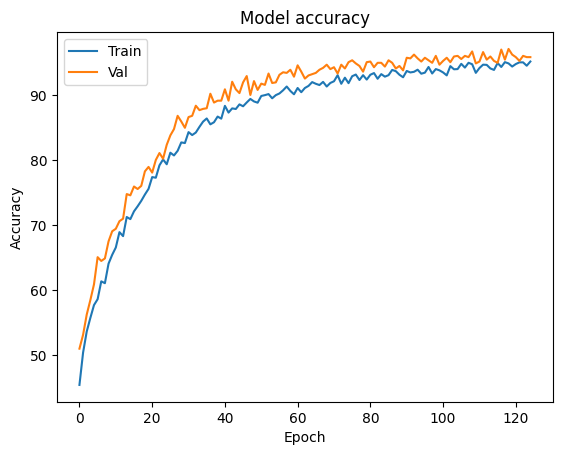

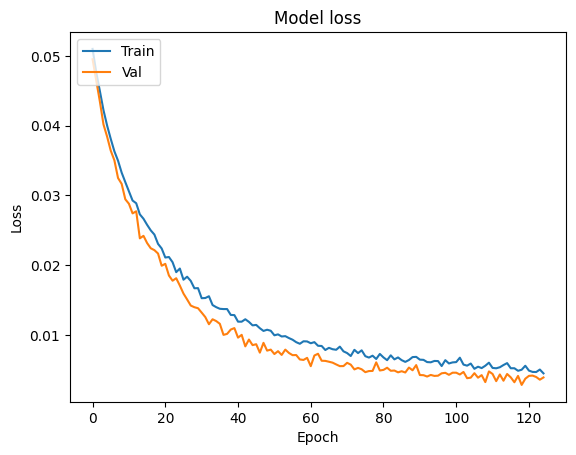

In [18]:
plt.plot(history[0][1])
plt.plot(history[1][1])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Val'], loc='upper left')
plt.show()

plt.plot(history[0][0])
plt.plot(history[1][0])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [19]:
model.eval()
running_corrects = 0
total_val_images = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        running_corrects += (predicted == labels).sum().item()
        total_val_images += labels.size(0)

    test_acc = 100 * running_corrects / total_val_images
print(f'Testing accuracy: {test_acc:.4f}%')

Testing accuracy: 99.5136%


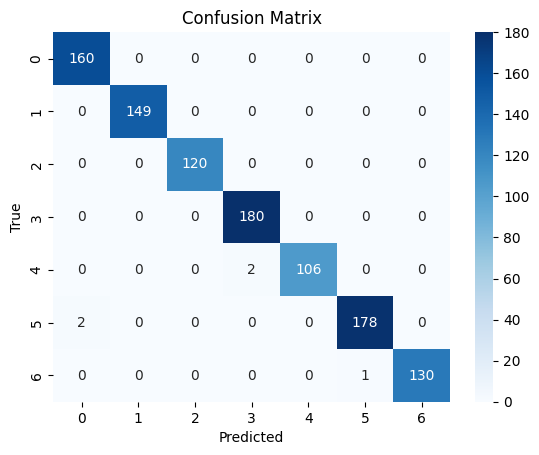

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       160
           1       1.00      1.00      1.00       149
           2       1.00      1.00      1.00       120
           3       0.99      1.00      0.99       180
           4       1.00      0.98      0.99       108
           5       0.99      0.99      0.99       180
           6       1.00      0.99      1.00       131

    accuracy                           1.00      1028
   macro avg       1.00      0.99      1.00      1028
weighted avg       1.00      1.00      1.00      1028



In [20]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

from sklearn.metrics import confusion_matrix, classification_report

confusion_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(y_true, y_pred)
print("Classification Report:\n", report)

In [21]:
torch.save(model, '/kaggle/working/model.pt')

# 4.deployment

In [32]:
%%writefile app.py

import streamlit as st
import torch
from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Normalize

st.title("Dental diseases classification App")

model = torch.load('/kaggle/working/model.pt')
model.eval()

class_labels = ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']

uploaded_file = st.file_uploader("Choose an image...")

deploy_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if uploaded_file is not None:
    # Load and preprocess the image
    image = Image.open(uploaded_file)
    image_tensor = deploy_transform(image)
    image_tensor = image_tensor.unsqueeze(0)

    # Make predictions
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        predicted_class = torch.argmax(outputs, dim=1).item()

    # Display results
    st.image(image, caption='Uploaded Image')
    st.write(f"Predicted Class: {class_labels[predicted_class]}")

Overwriting app.py


In [23]:
!npm install localtunnel

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


m#################.] - reify:yargs-parser: http fetch GET 200 https://registry.
added 22 packages in 2s

3 packages are looking for funding
  run `npm fund` for details
npm notice 
npm notice New minor version of npm available! 10.5.0 -> 10.8.2
npm notice Changelog: https://github.com/npm/cli/releases/tag/v10.8.2
npm notice Run npm install -g npm@10.8.2 to update!
npm notice 


In [24]:
!curl ipv4.icanhazip.com

34.75.243.196


In [34]:
!streamlit run app.py &>./logs.txt & npx localtunnel --port 8501

your url is: https://ten-lands-deny.loca.lt
^C


# 5.preview

In [36]:
url = 'https://drive.google.com/file/d/14cWSR1I6KHdWNtN2xqeWDknhoOs85HKA/view?usp=sharing'
output_path = '/kaggle/working/preview.webm'
gdown.download(url, output_path, quiet=False,fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=14cWSR1I6KHdWNtN2xqeWDknhoOs85HKA
To: /kaggle/working/preview.webm
100%|██████████| 645k/645k [00:00<00:00, 94.1MB/s]


'/kaggle/working/preview.webm'

In [39]:
from IPython.display import HTML
from base64 import b64encode

def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=1000 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

play('/kaggle/working/preview.webm')